In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'RL.csv'
fr = pd.read_csv(FILE)

In [18]:
Vin = np.array(fr['Vin']) # V
VR = np.array(fr['VR']) # V
VL = np.array(fr['VL']) # V
ν = np.array(fr['Freq (kHz)']) * 10**3# Hz 
ω = 2*np.pi*ν
ΦR = np.array(fr['faseR (deg)'], dtype=np.float64) * (np.pi / 180) # rad
ΦL = np.array(fr['faseL (deg)'], dtype=np.float64) * (np.pi / 180) # rad

sigma_Vin = 0.04
sigma_VR = np.array(fr['sigmaV_R']) /4 # media 4 = sqrt(16)
sigma_VL = np.array(fr['sigmaV_L']) /4

R = 9950 # ohm
sigmaR = R * 0.01 # errore associato ohmmetro
RL = 40
sigmaRL = RL * 0.01

sigma_ΦR = np.array(fr['sigmaF_R'], dtype=np.float64) * (np.pi/180.0) /4 # rad
sigma_ΦL = np.array(fr['sigmaF_L'], dtype=np.float64) * (np.pi/180.0) /4 # rad

### FUNZIONE DI TRASFERIMENTO $H_R(\omega)$:

- $|H_R(\omega)| = \frac{R}{\sqrt{(R+R_L)^2 + \omega^2 L^2}}$
- $\angle H_R(\omega) = -arctan(\frac{\omega L}{R+R_L})$

In [19]:
# definizione funzione modulo e argomento

def mod_HR_f(ω, L): # R noto
    num = R
    den2 = (R+RL)**2 + ω**2 * L**2
    return num/np.sqrt(den2)

def arg_HR_f(ω,L):
    return -np.arctan(ω*L / (R + RL))

In [20]:
# calcolo funzione di trasferimento dal rapporto tra Vout/Vin

modHR = VR/Vin
sigma_modHR = np.sqrt(((VR/(Vin**2))*sigma_Vin)**2 + ((1/(Vin))*sigma_VR)**2)

In [21]:
# interpolazione

L_guess =0.04 # usa la resistenza fissata
fit_mod_HR = Interpolazione(ω,modHR,mod_HR_f,sigma_modHR,p0=[L_guess])
fit_arg_HR = Interpolazione(ω,ΦR,arg_HR_f,sigma_ΦR,p0=[L_guess])

print("---------------------------MODULO R-------------------------")
print(fit_mod_HR)
print("---------------------------FASE R-------------------------")
print(fit_arg_HR)

---------------------------MODULO R-------------------------
   
Parameters: [0.04928967] 
Sigma parameters: [0.00277377]

sigmaY: [0.01611722 0.01662543 0.01637317 0.01586942 0.01552614 0.01205232
 0.00926847 0.00809122]

chiquadro ridotto: 10.73
df: 7
pvalue: 15.1%
covariance matrix: [[5.89056473e-06]]    

---------------------------FASE R-------------------------
   
Parameters: [0.05399811] 
Sigma parameters: [0.00636899]

sigmaY: [0.00436332 0.00436332 0.00436332 0.00436332 0.00436332 0.00872665
 0.00872665 0.02181662]

chiquadro ridotto: 65.25
df: 7
pvalue: 0.0%
covariance matrix: [[3.10568587e-05]]    



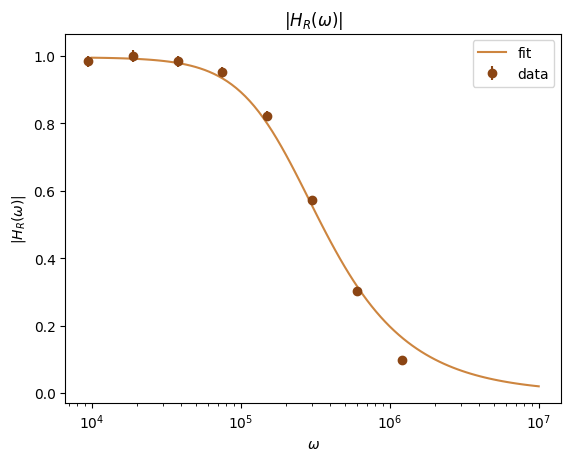

In [22]:
# rappressentazione modulo HR

x = np.logspace(4,7,100)
y = mod_HR_f(x,*fit_mod_HR.bval)

plt.title('$|H_R(\omega)|$')
plt.errorbar(ω,modHR,yerr=fit_mod_HR.sigmaY,fmt='o',label='data',color='saddlebrown')
plt.plot(x,y,label='fit',color='peru')
plt.xscale('log')
plt.ylabel('$|H_R(\omega)|$')
plt.xlabel('$\omega$')
plt.legend()
plt.show()

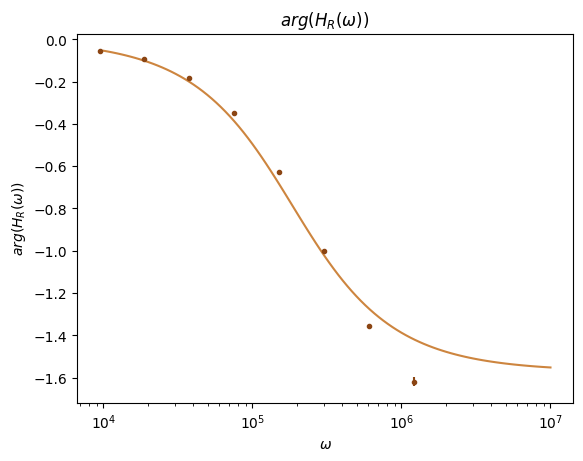

In [23]:
# rappresentazione argomento HR

x = np.logspace(4,7,100)
y = arg_HR_f(x,*fit_arg_HR.bval)

plt.title('$arg(H_R(\omega))$')
plt.errorbar(ω,ΦR,yerr=fit_arg_HR.sigmaY,fmt='.',color='saddlebrown',label='data')
plt.plot(x,y,color='peru',label='fit')
plt.xscale('log')
plt.ylabel('$arg(H_R(\omega))$')
plt.xlabel('$\omega$')
plt.show()

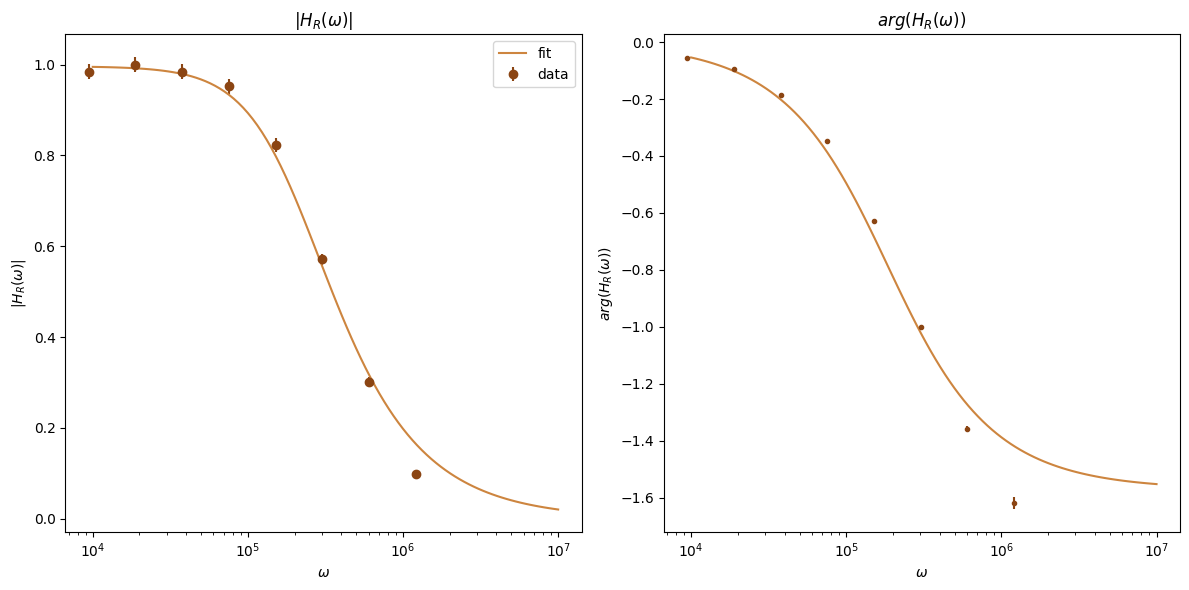

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Modulo HR
x = np.logspace(4, 7, 100)
y = mod_HR_f(x, *fit_mod_HR.bval)
axs[0].set_title('$|H_R(\omega)|$')
axs[0].errorbar(ω, modHR, yerr=fit_mod_HR.sigmaY, fmt='o', label='data', color='saddlebrown')
axs[0].plot(x, y, label='fit', color='peru')
axs[0].set_xscale('log')
axs[0].set_ylabel('$|H_R(\omega)|$')
axs[0].set_xlabel('$\omega$')
axs[0].legend()

# Plot 2: Argomento HR
x = np.logspace(4, 7, 100)
y = arg_HR_f(x, *fit_arg_HR.bval)
axs[1].set_title('$arg(H_R(\omega))$')
axs[1].errorbar(ω, ΦR, yerr=fit_arg_HR.sigmaY, fmt='.', color='saddlebrown', label='data')
axs[1].plot(x, y, color='peru', label='fit')
axs[1].set_xscale('log')
axs[1].set_ylabel('$arg(H_R(\omega))$')
axs[1].set_xlabel('$\omega$')

plt.tight_layout()
plt.show()


### FUNZIONE DI TRASFERIMENTO $H_L(\omega)$:

- $|H_L(\omega)| = \frac{\sqrt{R_L^2 + \omega^2 L^2}}{\sqrt{(R+R_L)^2 + \omega^2 L^2}}$
- $\angle H_L(\omega) = arctan(\frac{\omega L}{R_L}) - arctan(\frac{\omega L}{R+R_L})$

In [25]:
# definizione modulo argomento funzione di trasferimento HL

def mod_HL_f(ω, L): # R noto, RL noto
    num = np.sqrt(RL**2 + ω**2 * L**2)
    den2 = (R+RL)**2 + ω**2 * L**2
    return num/np.sqrt(den2)

def arg_HL_f(ω,L):
    return np.arctan(ω*L/RL) -np.arctan(ω*L / (R + RL))

In [26]:
# calcolo H = Vout/Vin
modHL = VL/Vin
sigma_modHL = np.sqrt(((VL/(Vin**2))*sigma_Vin)**2 + ((1/(Vin))*sigma_VL)**2)

In [27]:
# fit

L_guess =0.04 # usa la resistenza fissata
fit_mod_HL = Interpolazione(ω,modHL,mod_HL_f,sigma_modHL,p0=[L_guess])
fit_arg_HL = Interpolazione(ω,ΦL,arg_HL_f,sigma_ΦL,p0=[L_guess])

print("---------------------------MODULO L-------------------------")
print(fit_mod_HL)
print("---------------------------FASE L-------------------------")
print(fit_arg_HL)

---------------------------MODULO L-------------------------
   
Parameters: [0.04985827] 
Sigma parameters: [0.00186623]

sigmaY: [0.00800024 0.00821418 0.00855717 0.00974071 0.01043586 0.01393064
 0.01611722 0.01660607]

chiquadro ridotto: 2.2
df: 7
pvalue: 94.8%
covariance matrix: [[2.6665167e-06]]    

---------------------------FASE L-------------------------
   
Parameters: [0.04678545] 
Sigma parameters: [0.00464108]

sigmaY: [0.06544985 0.04363323 0.02181662 0.02181662 0.00872665 0.00872665
 0.00436332 0.00436332]

chiquadro ridotto: 56.63
df: 7
pvalue: 0.0%
covariance matrix: [[1.6491294e-05]]    



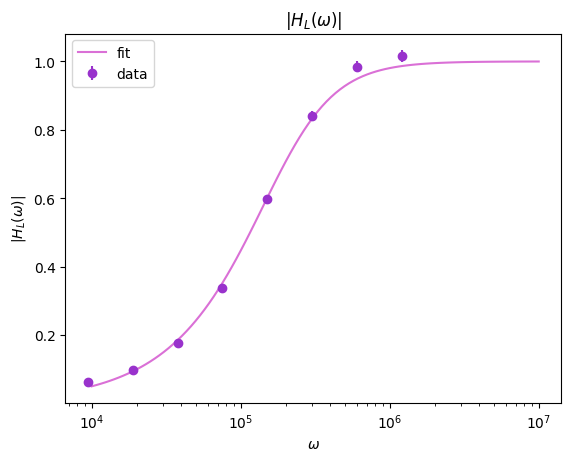

In [28]:
# rappresentazione modulo HL

x = np.logspace(4,7,100)
y = mod_HL_f(x,*fit_mod_HL.bval)

plt.title('$|H_L(\omega)|$')
plt.errorbar(ω,modHL,yerr=fit_mod_HL.sigmaY,fmt='o',label='data',color='darkorchid')
plt.plot(x,y,label='fit',color='orchid')
plt.xscale('log')
plt.ylabel('$|H_L(\omega)|$')
plt.xlabel('$\omega$')
plt.legend()
plt.show()

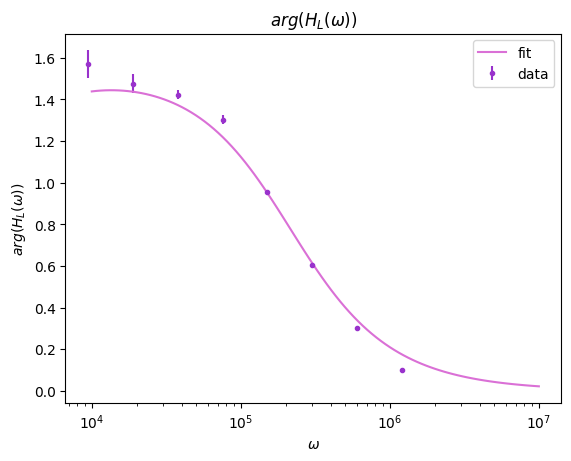

In [29]:
# rappresentazione argomento HL

x = np.logspace(4,7,100)
y = arg_HL_f(x,*fit_arg_HL.bval)

plt.title('$arg(H_L(\omega))$')
plt.errorbar(ω,ΦL,yerr=fit_arg_HL.sigmaY,fmt='.',color='darkorchid',label='data')
plt.plot(x,y,label='fit',color='orchid')
plt.xscale('log')
plt.ylabel('$arg(H_L(\omega))$')
plt.xlabel('$\omega$')
plt.legend()
plt.show()

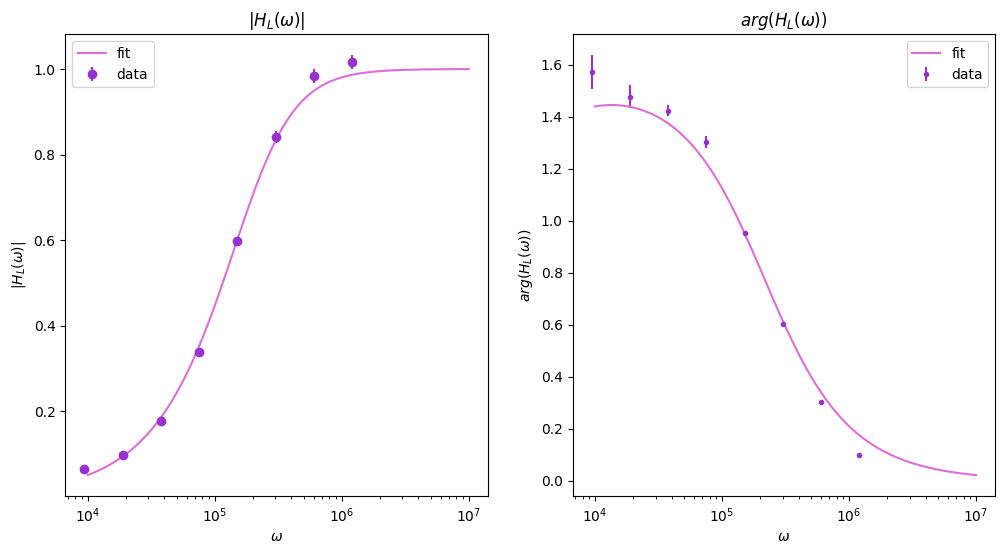

In [30]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 6))

# rappresentazione modulo HL

x = np.logspace(4,7,100)
y = mod_HL_f(x,*fit_mod_HL.bval)

ax1.set_title('$|H_L(\omega)|$')
ax1.errorbar(ω,modHL,yerr=fit_mod_HL.sigmaY,fmt='o',label='data',color='darkorchid')
ax1.plot(x,y,label='fit',color='orchid')
ax1.set_xscale('log')
ax1.set_ylabel('$|H_L(\omega)|$')
ax1.set_xlabel('$\omega$')
ax1.legend()

# rappresentazione argomento HL

x = np.logspace(4,7,100)
y = arg_HL_f(x,*fit_arg_HL.bval)

ax2.set_title('$arg(H_L(\omega))$')
ax2.errorbar(ω,ΦL,yerr=fit_arg_HL.sigmaY,fmt='.',color='darkorchid',label='data')
ax2.plot(x,y,label='fit',color='orchid')
ax2.set_xscale('log')
ax2.set_ylabel('$arg(H_L(\omega))$')
ax2.set_xlabel('$\omega$')
ax2.legend()

plt.show()